Load the dataset of the meeting of all years combined.

In [ ]:
import pandas as pd
df = pd.read_csv("combined_data_adam.csv")

/tmp/ipykernel_30772/89575442.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("combined_data_adam.csv")


extracting the demographic features and demogratic votes for each one of the 647 unique places\areas.

In [ ]:
non_null_counts = df.notnull().sum()
regression_df = df[["place_Pres_dem2pv_last","census_2010_pop", "census_2010_pop_est","census_2015_pop_est","acs_2018_white", "acs_2018_black","acs_2018_hispanic","acs_2018_pop", "place_name", "year"]]
regression_df = regression_df.dropna()
regression_df = regression_df.drop_duplicates()
regression_df = regression_df.loc[regression_df.groupby('place_name')['year'].idxmax()].drop(columns = ["year","place_name"])
regression_df

,place_Pres_dem2pv_last,census_2010_pop,census_2010_pop_est,census_2015_pop_est,acs_2018_white,acs_2018_black,acs_2018_hispanic,acs_2018_pop
98331,0.257900,8191.0,8188.0,8119.0,7457.0,268.0,169.0,8020.0
9374,0.594010,31765,31679.0,33166.0,20417.0,6862.0,21616.0,33416.0
96002,0.384500,29524.0,29645.0,30604.0,20493.0,8462.0,612.0,30464.0
94882,0.627800,199110.0,198972.0,197542.0,119253.0,59643.0,4854.0,198314.0
74074,0.860500,73812,73969.0,78630.0,38101.0,5607.0,9406.0,78462.0
...,...,...,...,...,...,...,...,...
81472,0.371300,25719,25674.0,25976.0,21525.0,3600.0,397.0,26364.0
98799,0.419000,91067.0,91680.0,93701.0,70600.0,1593.0,43341.0,93416.0
95824,0.373000,1024.0,1024.0,1094.0,1154.0,0.0,106.0,1353.0
6831,0.942319,11443,11454.0,11523.0,799.0,10284.0,183.0,11487.0


### Linear regression

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


In [ ]:
# Splitting the dataset into features and label
X = regression_df.drop('place_Pres_dem2pv_last', axis=1)  # Features
y = regression_df['place_Pres_dem2pv_last']  # Label

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data
X_test_scaled = scaler.transform(X_test)


In [ ]:
# Initialize the Linear Regression model
model = LinearRegression()

# Train the model with scaled data
model.fit(X_train_scaled, y_train)


LinearRegression()

In [ ]:
# Predicting the test set results using scaled data
y_pred = model.predict(X_test_scaled)

# Calculating and printing the R squared value
r2 = r2_score(y_test, y_pred)
print(f"R squared value: {r2:.2f}")

# Calculating and printing the Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")


R squared value: -0.00
Mean Squared Error: 0.04


In [ ]:
coeff_df = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print(coeff_df)


                     Coefficient
census_2010_pop         2.351315
census_2010_pop_est    -3.077452
census_2015_pop_est     1.705286
acs_2018_white         -0.231012
acs_2018_black         -0.105661
acs_2018_hispanic      -0.009479
acs_2018_pop           -0.596922


In [ ]:
!pip install shap

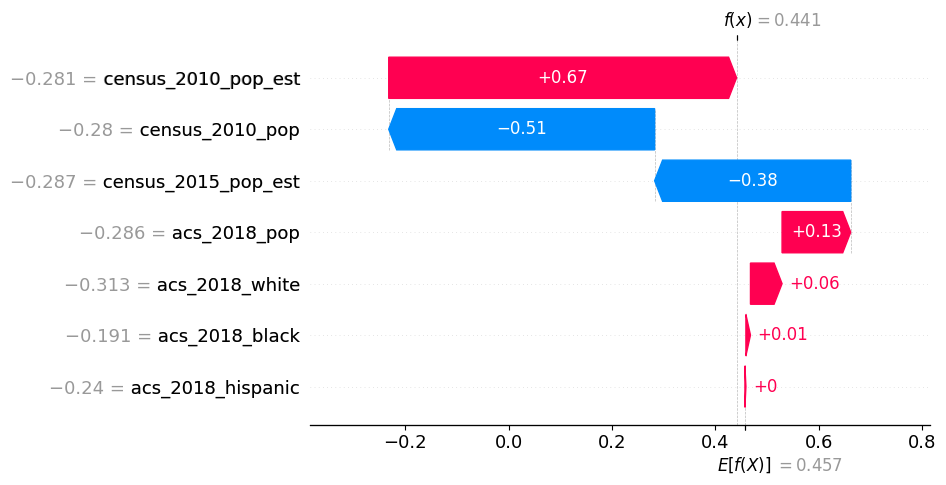

In [ ]:
import shap
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Assuming regression_df is your DataFrame
X = regression_df.drop('place_Pres_dem2pv_last', axis=1)
y = regression_df['place_Pres_dem2pv_last']

# Split and scale data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled data back to DataFrame to retain column names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

# Train a model
model = LinearRegression()
model.fit(X_train_scaled_df, y_train)

# Use SHAP to explain the model's predictions
explainer = shap.Explainer(model, X_train_scaled_df)
shap_values = explainer(X_test_scaled_df)

# Plot the SHAP values for a single prediction (e.g., the first prediction)
shap.plots.waterfall(shap_values[0])



It can be seen that, The linear model failed with this regression task, as we can see. Probably a non linear model is needed to model the relationships between the features and the label better.

### Non linear models

**We will perform hyper parameter tuning on the training set, choose the best hyper-parametrs and train a new model on the entire training set, evaluate each model with MAE, MSE, R^2 and Shap plots:**

Best hyperparameters for Decision Tree:
{'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10}


Evaluation metrics for Decision Tree with best hyperparameters:
Mean Squared Error: 0.03
Mean Absolute Error: 0.13
R squared value: 0.21

Feature Importance based on SHAP values for Decision Tree:
acs_2018_black         0.064350
acs_2018_white         0.054308
acs_2018_hispanic      0.050611
census_2010_pop_est    0.017876
census_2015_pop_est    0.017230
census_2010_pop        0.011055
acs_2018_pop           0.005401
dtype: float64


SHAP Summary Plot for Decision Tree


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


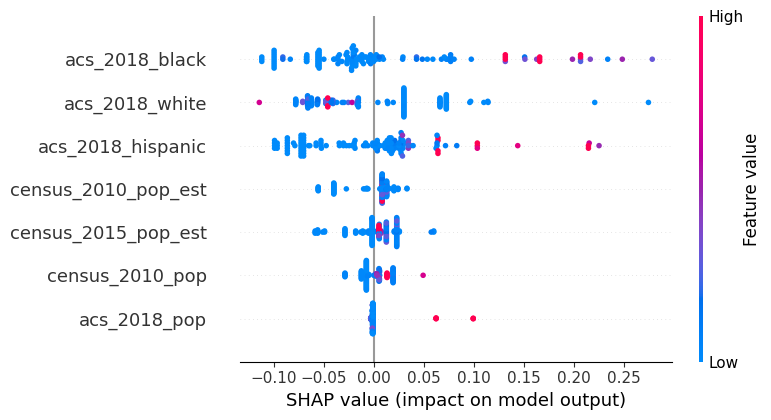

Best hyperparameters for Random Forest:
{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}


Evaluation metrics for Random Forest with best hyperparameters:
Mean Squared Error: 0.02
Mean Absolute Error: 0.12
R squared value: 0.34

Feature Importance based on SHAP values for Random Forest:
acs_2018_black         0.057456
acs_2018_white         0.054083
acs_2018_hispanic      0.044691
census_2015_pop_est    0.013471
census_2010_pop        0.011734
census_2010_pop_est    0.010805
acs_2018_pop           0.007914
dtype: float64


SHAP Summary Plot for Random Forest


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


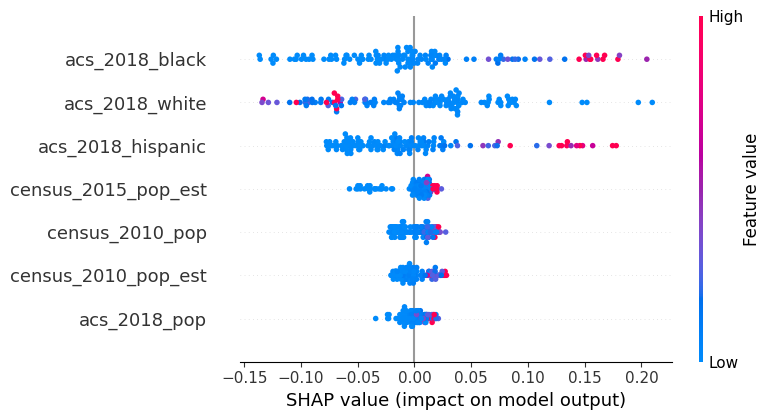

Best hyperparameters for XGBoost:
{'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.9}


Evaluation metrics for XGBoost with best hyperparameters:
Mean Squared Error: 0.03
Mean Absolute Error: 0.12
R squared value: 0.33

Feature Importance based on SHAP values for XGBoost:
acs_2018_white         0.053316
acs_2018_black         0.048662
acs_2018_hispanic      0.039424
census_2010_pop        0.020532
census_2015_pop_est    0.013089
census_2010_pop_est    0.008285
acs_2018_pop           0.006497
dtype: float64


SHAP Summary Plot for XGBoost


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


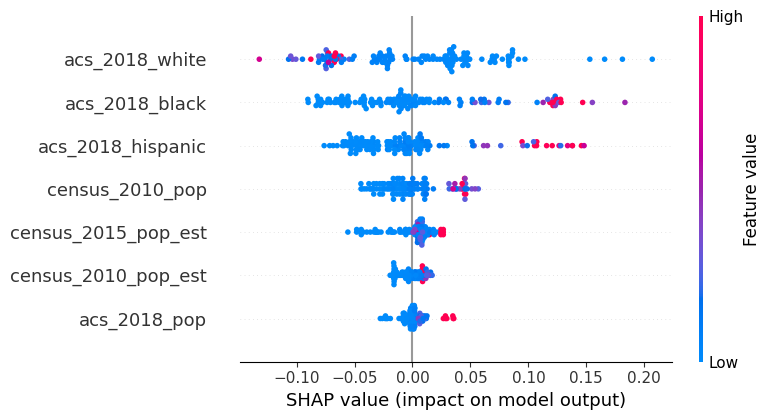

In [ ]:
import pandas as pd
import shap
from sklearn.metrics import mean_absolute_error  # Importing the necessary function
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

# Assuming regression_df is your DataFrame
X = regression_df.drop('place_Pres_dem2pv_last', axis=1)
y = regression_df['place_Pres_dem2pv_last']

# Split and scale data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled data back to DataFrame to retain column names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

# Hyperparameter grids
dt_params = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

xgb_params = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1]
}

# Models and their parameter grids
models = {
    'Decision Tree': (DecisionTreeRegressor(), dt_params),
    'Random Forest': (RandomForestRegressor(), rf_params),
    'XGBoost': (xgb.XGBRegressor(), xgb_params)
}

# Hyperparameter tuning with cross-validation using R^2 as the scoring metric
for model_name, (model, params) in models.items():
    grid_search = GridSearchCV(model, params, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train_scaled_df, y_train)

    # Print best hyperparameters
    print(f"Best hyperparameters for {model_name}:")
    print(grid_search.best_params_)
    print("\n")

    # Train the best model on the entire training set
    best_model = grid_search.best_estimator_
    best_model.fit(X_train_scaled_df, y_train)

    # Predictions
    y_pred = best_model.predict(X_test_scaled_df)

    # Evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)  # Calculating MAE
    r2 = r2_score(y_test, y_pred)
    print(f"Evaluation metrics for {model_name} with best hyperparameters:")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Mean Absolute Error: {mae:.2f}")  # Printing MAE
    print(f"R squared value: {r2:.2f}\n")

    # SHAP interpretation
    explainer = shap.Explainer(best_model, X_train_scaled_df)
    shap_values = explainer(X_test_scaled_df, check_additivity=False)  # Disable additivity check

    # Convert shap values to a DataFrame for easier manipulation
    shap_df = pd.DataFrame(shap_values.values, columns=X_test_scaled_df.columns)

    # Compute mean absolute SHAP value for each feature
    mean_shap = shap_df.abs().mean()

    # Rank features based on mean absolute SHAP value
    ranked_features = mean_shap.sort_values(ascending=False)

    print(f"Feature Importance based on SHAP values for {model_name}:")
    print(ranked_features)
    print("\n")

    # If you still want to visualize the SHAP summary plot
    print(f"SHAP Summary Plot for {model_name}")
    shap.summary_plot(shap_values, X_test_scaled_df, title = f"Shap Plot - {model_name}")

